In [1]:
###################################
######## IMPORT DIRECTIVES ########
###################################
import sys

!{sys.executable} -m pip install scipy

import numpy.fft as ft
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import copy as cp

from mpl_toolkits.mplot3d import Axes3D
import time as t
import types as tp
import math as m
import cmath as cm
import pandas as pd

import scipy as scp
import scipy.interpolate as scpi
import scipy.sparse as scps
import scipy.sparse.linalg as scpl
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix
import scipy.interpolate as scin
import scipy.fftpack as scpf

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import re
import os

import gaussianMeshMethods as GMM

###################################
###################################

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [81]:
####################################################
######## gaussian mesh generator parameters ########
####################################################

shape = [200]
boundValues = [(-50.0, 50.0)]

mu = 0
meanFunction = lambda coord : mu

sigma = 0.05
greatestDistanceOfCorrelation = 8
covarianceFunction = lambda coordI, coordII : sigma**2*np.exp(-(np.linalg.norm(coordI - coordII)/greatestDistanceOfCorrelation)**2)

units = ["nm", "nm"]
meshTitle = "Gaussian Surface"
axisLegends = ["Axis X", "Surface height"]
description = "Distance de correlation maximale : 2.0 nm\n"
description += "RMS : 0.2 nm"

####################################################
####################################################

GM1D = GMM.gaussianMesh(shape,
                        boundValues,
                        meanFunction,
                        covarianceFunction,
                        greatestDistanceOfCorrelation,
                        units,
                        meshTitle,
                        axisLegends,
                        description)

GM1D.getPlot1D_VII(GM1D.ffmMethodComputedMeshValues)
## GM1D.saveMeshHandler()
zeta = GM1D.getInterpolation(GM1D.ffmMethodComputedMeshValues)

####################################################
####################################################

MEAN VALUES VECTOR CONSTRUCTION.... IN PROGRESS
MEAN VALUES VECTOR CONSTRUCTION.... FINISHED
COVARIANCE FUNCTION FOURIER TRANSFORM COMPUTATION.... IN PROGRESS
COVARIANCE FUNCTION FOURIER TRANSFORM COMPUTATION.... FINISHED
FFM METHOD MESH VALUES COMPUTATION.... IN PROGRESS
FFM METHOD MESH VALUES COMPUTATION.... FINISHED


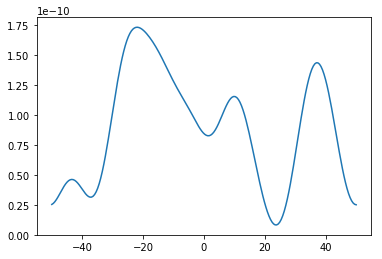

In [87]:
def zeta1d(x):
    xx = np.linspace(-boundValues[0][0],boundValues[0][1],shape[0])
    #print(np.min((zeta(xx))))
    return ((zeta(x) +0.1)*1e-9)

xx=np.linspace(boundValues[0][0],boundValues[0][1],shape[0])
plt.plot(xx,zeta1d(xx))

Solving the inverse problem:\\

Rayleigh equation:\\

($\star$) Find $R$ such as:\\
$\int_{-\infty}^{\infty} M^{(+)} (p|q)R(q|k) \frac{dq}{2\pi} = -M^{(-)}(p|k)$ $\forall (p,k) \in \mathbb{R}^2$\\

We want to solve it numerically. 
So we first approximate $\int_{-\infty}^{\infty} M^{(+)} (p|q)R(q|k) \frac{dq}{2\pi} \approx \int_{-A}^{A} M^{(+)} (p|q)R(q|k) \frac{dq}{2\pi}$ with $A>>1$ . \\

Secondly we discretize $[-A,A]$  in $N-1$ intervals. And then we approach the integral : $\int_{-A}^A M^{(+)} (p|q)R(q|k) \frac{dq}{2\pi}$ using the N points of the previous subdivision. (we use a simple method of integration: rectangle rule)\\

So ($\star$) becomes:\\

($\star$): Find $\textbf{R} \in \mathcal{M}_{N-1} (\mathbb{C})$ such that: \\

$\sum_\limits {n=0}^{N-2} \textbf{M}^{(+)}_{j,n} \textbf{R}_{n,l} = - \frac{2\pi}{h} \textbf{M}^{(-)}_{j,l}$ 

where: $\textbf{R}_{a,b} := R(q_a|k_b)$ , $ \textbf{M}^{(\pm)}_{a,b} := M^{(\pm)}(p_a|q_b)$ and $h = \frac{2A}{N-1}$\\

We reformulate this problem into a matrix unknown system:\\
$$ \textbf{M}^{(+)} \textbf{ R }= -\frac{2\pi}{h} \textbf{M}^{(-)}$$, 

where $\textbf{M}^{(\pm)}, \textbf{R} \in \mathcal{M}_{N-1}(\mathbb{C})$.\\
This system can be interpreted as a list of ($N-1$) vectorial unknown systems:
$$\forall l = 0, ... , N-2 : \textbf{M}^{(+)} \textbf{R}_{\bullet,l} = -\frac{2\pi}{h} \textbf{M}^{(-)}_{\bullet,l}$$.

Thus if $\textbf{M}^{(+)}$ is inversible then ($\star$) admits an unique solution. But generally it is not the case!\\

So we opt for a variationnal point of view:\\

$(\star \star): Solve : \forall l=0,...,N-2: \displaystyle \arg \inf_{\textbf{R}_{.,l} \in \mathbb{R}^{N-1}} \frac1 2 \Vert \textbf{M}^{(+)}\textbf{R}_{.,l} + \frac{2\pi}{h} \textbf{M}^{(-)}_{.,l} \Vert_2 ^2$ \\

Numerically we can solve $(\star \star)$ by using a gradient descent algorithm.\\

Algorithm to solve : $ \displaystyle \arg \inf_{v \in \mathbb{R}^{N-1}} \frac1 2 \Vert \textbf{M}^{(+)}v + \frac{2\pi}{h} \textbf{M}^{(-)}_{.,l} \Vert_2 ^2 $\\

1) Start with $v^0 \in \mathbb{R}^{N-1}$\\

2) For $k \geq 0$: $v^{k+1} = v^{k} -s{\textbf{M}^{(+)}}^T (\textbf{M}^{(+)}v^k+ \frac{2\pi}{h}\textbf{M}^{(-)}_{.,l}) $\\

We choose the constant step $s = 1/L$ with $L = \vert\vert \vert {\textbf{M}^{(+)}}^T \textbf{M}^{(+)}\vert\vert \vert_2$. This choice of $s$ provides the algorithm convergence.

In [113]:
LAMBDA = 589.3e-9 #m (red)
c = 299792458 #m/s
w = 2*np.pi*c/LAMBDA #petarad/s 10**15
theta_0 = np.pi/6
k0 = (w/c) *np.sin(theta_0)
print(k0*1e-6)
n = 1.5886 #indice
epsilon_r = np.sqrt(n)
epsilon_0 = 8.8542e-12 #SI
exponent=0 #exponent = 1 for p-polarisation and 0 for s-polarisation
eps = lambda w: epsilon_r * epsilon_0 #dielectric function

5.331058295587633


In [114]:
def alpha(p,w):
    if eps(w)*(w/c)**2 -p**2 >=0:
        return (eps(w)*(w/c)**2 -p**2)**0.5
    else:
        return 1j*(-eps(w)*(w/c)**2 +p**2)**0.5
def alpha0(p,w):
    if (w/c)**2 -p**2 >=0:
        return ((w/c)**2 -p**2)**0.5
    else:
        return 1j*(-(w/c)**2 +p**2)**0.5
    
def TF(func,bound,N):
    grid = np.linspace(-bound,bound,N)
    echant = func(grid)
    hat_echant = ft.fftshift(ft.fft(echant))
    grid_freq = np.arange(-N//2,N//2)/A/2
    pos_neg = lambda k: 1 *(k%2 ==0) -1*(k%2 !=0)
    tab = pos_neg(np.arange(-N//2,N//2))
    return scin.CubicSpline(grid_freq, 2*A/N *tab *hat_echant)

def TFzeta_n(n,Q):
    N = shape[0]
    bound = boundValues[0][1]
    integrand = lambda x: zeta1d(x)**n 
    
    return TF(integrand,bound,N)(Q/(2*np.pi))

def mu_pos(n,p,q):
    if exponent ==1:
        return (-1j)**n *(p*q +alpha(p,w)*alpha0(q,w)) *(alpha(p,w)-alpha0(q,w))**(n-1)
    elif exponent ==0:
        return (-1j)**n *(alpha(p,w)-alpha0(q,w))**(n-1)
        
def mu_neg(n,p,q):
    if exponent ==1:
        return (-1j)**n *(p*q -alpha(p,w)*alpha0(q,w)) *(alpha(p,w)+alpha0(q,w))**(n-1) 
    elif exponent ==0:
        return (-1j)**n  *(alpha(p,w)+alpha0(q,w))**(n-1) 
        
def M_pos(p,q):
    s=0
    for n in range(1,10):
        s +=mu_pos(n,p,q)*TFzeta_n(n,p-q)
    return s
    
                        
def M_neg(p,q):
    s=0
    for n in range(1,10):
        s +=mu_neg(n,p,q)*TFzetan(n,p-q)
    return s


In [115]:
def matrices_syst(grid_R):
    N=len(grid_R)-1
    mat_pos=np.zeros((N,N),dtype=complex)
    mat_neg=np.zeros((N,N),dtype=complex)
    for i in range(N):
        for j in range(N):
            mat_pos[i,j] = M_pos(grid_R[i],grid_R[j])
            mat_neg[i,j] = M_neg(grid_R[i],grid_R[j])
    plt.imshow(np.abs(mat_pos))
    plt.colorbar()
    plt.show()
    plt.imshow(np.abs(mat_neg))
    plt.colorbar()
    plt.show()
    return mat_pos,mat_neg

    
def mat_R(grid_R):
    N=len(grid_R)-1
    h=grid_R[1]-grid_R[0]
    print("Assembly of matrices in progress")
    
    mat_pos,mat_neg=matrices_syst(grid_R)
    s = 1/(np.linalg.norm((mat_pos.T).dot(mat_pos)))
    R=np.zeros((N,N),dtype=complex)
    print("Assembly of matrices finished")
    Nmax = 100
    
    for j in range(Nmax):
        grad = (mat_pos.T).dot(mat_pos.dot(R)+(2*np.pi/h)*mat_neg)
        R -= s*(grad)/np.linalg.norm(grad)
    print("ERROR = ",np.linalg.norm(mat_pos.dot(R)+(2*np.pi/h)*mat_neg,np.inf))
    #plt.imshow(np.abs(mat_pos.dot(R)+(2*np.pi/h)*mat_neg))
    #plt.colorbar()
    #plt.title("ERROR im")
    #plt.show()
    #print((mat_pos.dot(R)+(2*np.pi/h)*mat_neg)[50,50])
    return R,mat_pos,mat_neg

Assembly of matrices in progress


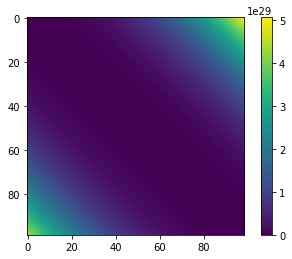

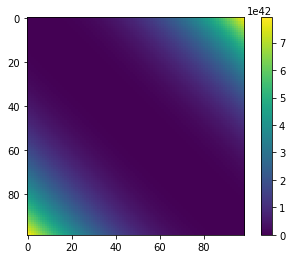

Assembly of matrices finished
ERROR =  6.100879504310959e+38


In [116]:
A,N = 10**8,100
grid_R = np.linspace(-A,A,N) #grid on a 'large' interval of ]-inf,+inf[
R_matrix,M_p,M_n = mat_R(grid_R)

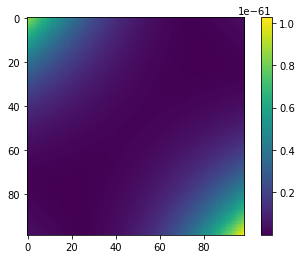

In [117]:
plt.imshow(np.abs(R_matrix))
plt.colorbar()

In [118]:
theta0_index = 50

In [119]:
Sample =  R_matrix[theta0_index,:]
Derivative_Sample = (Sample[1:]-Sample[0:-1])/(2*A/(N-1))


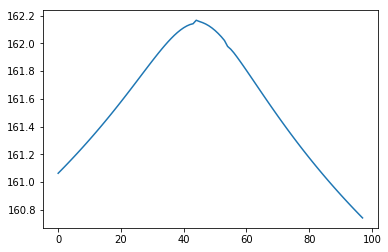

In [120]:
plt.plot(-np.log(np.abs(Derivative_Sample))) #fixer wave number incident

plt.show()

